In [1]:
import scipy.stats as sps
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chisquare

#Убираем FutureWarning для лучшей читаемости
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

## Загрузка данных

In [2]:
df=pd.read_csv('Data.csv')

## Преобразование данных

In [3]:
# Приведение даты к виду: Год-месяц-день к строковому типу данных

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%Y-%m-%d')
df['InvoiceDate'] = df['InvoiceDate'].dt.strftime('%Y-%m-%d')

In [4]:
# Выборка положительных значений

df=df[(df['Quantity']>0) & (df['Price']>0.00)]

In [5]:
# Расчет суммы чека

df['Total']=df['Quantity']*df['Price']

In [6]:
#Группировка в разрезе дня по клиентам

df_group=df.groupby(['InvoiceDate', 'Customer ID']).agg({'Total': ['sum']}). reset_index()
df_group.columns = df_group.columns.droplevel(1)
df_group['Customer ID'] = df_group['Customer ID'].astype(str)
df_group['id'] = df_group['InvoiceDate'] +'_'+df_group['Customer ID']
df_res=df_group[['id', 'Total']]

## Визуализация данных

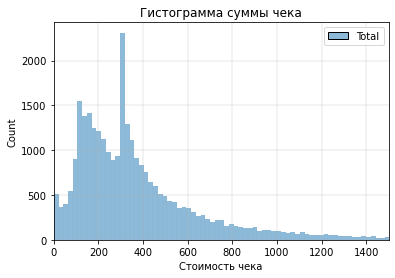

In [7]:
# Гистограмма суммы чека исходных данных

sns.histplot(df_res)
plt.title("Гистограмма суммы чека")
plt.xlabel("Стоимость чека")
plt.grid(linewidth=0.3) 
plt.xlim(0, 1500)
plt.show()

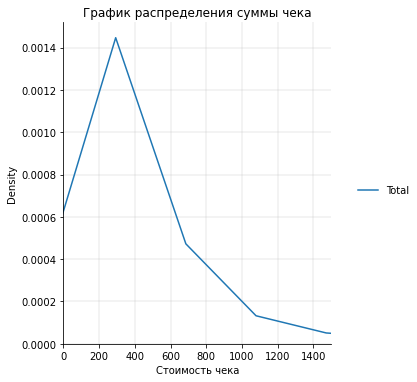

In [8]:
# Распределение суммы чека исходных данных

sns.displot(df_res, kind='kde')
plt.title("График распределения суммы чека")
plt.xlabel("Стоимость чека")
plt.grid(linewidth=0.3) 
plt.xlim(0, 1500)
plt.show()

In [9]:
# Приведение суммы чека к челочисленному типу

df_res.loc[:, 'Total']=df_res.loc[:, 'Total'].astype('int')

C:\Users\12967\AppData\Local\Temp\ipykernel_13280\4281180841.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_res.loc[:, 'Total']=df_res.loc[:, 'Total'].astype('int')


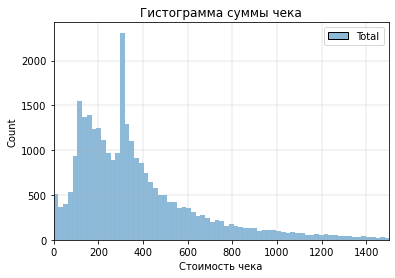

In [10]:
# Гистограмма суммы чека преобразованных данных

sns.histplot(df_res)
plt.title("Гистограмма суммы чека")
plt.xlabel("Стоимость чека")
plt.grid(linewidth=0.3) 
plt.xlim(0, 1500)
plt.show()

## Теоретическое распределение

In [11]:
# Массив значений x, принадлежащий диапазону min(Total)-max(Total)

x = np.linspace (df_res['Total'].min(), df_res['Total'].max(), df_res['Total'].shape[0])

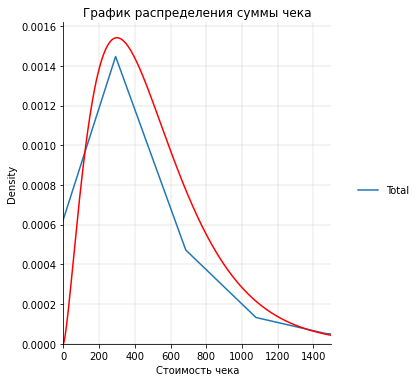

In [12]:
# Теоретическое гамма распределение

y1 = sps.gamma.pdf (x, a=2.5 , scale=200)
sns.displot(df_res, kind='kde', label='Total')
plt.plot (x, y1, color='red', label='distribution')
plt.xlim(0,300)
plt.title("График распределения суммы чека")
plt.xlabel("Стоимость чека")
plt.grid(linewidth=0.3) 
plt.xlim(0, 1500)
plt.show()

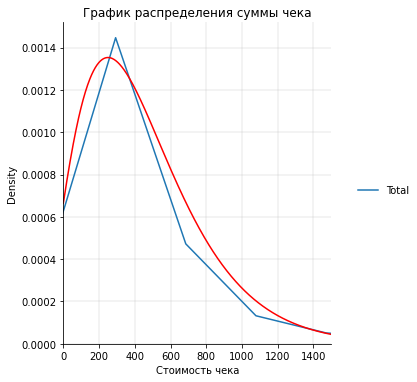

In [13]:
# Теоретическое хи распределение

y2 = sps.chi2.pdf (x,6 ,loc=-150, scale=100)
sns.displot(df_res, kind='kde', label='Total')
plt.plot (x, y2, color='red', label='distribution')
plt.xlim(0,300)
plt.title("График распределения суммы чека")
plt.xlabel("Стоимость чека")
plt.grid(linewidth=0.3) 
plt.xlim(0, 1500)
plt.show()

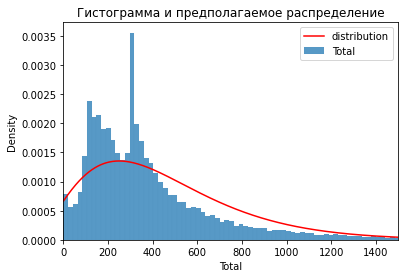

In [14]:
sns.histplot(df_res['Total'], stat='density', label='Total')
plt.plot(x, y2, color='red', label='distribution')
plt.legend()
plt.title('Гистограмма и предполагаемое распределение')
plt.xlim(0,1500)
plt.show()

## Экспериментальное распределение

In [15]:
# Подсчитываем, сколько раз каждая сумма чека встречалась в выборке

counts = df_res.groupby('Total').size() 

In [16]:
a=df_res['Total'].max() # Самая большая сумма в чеке
full_counts = np.zeros(a)  # Массив из нулей, где количество элементов равно самой большой сумме в чеке
for i in list(counts.index):      # Ищем вероятности для каждой суммы
    full_counts[i-1] = counts.loc[i]


In [17]:
num, points = np.histogram(full_counts, bins=540)  # Разбиваем гистограмму на промежутки

In [18]:
obs_freq = num.astype(float)/sum(num)  # Массив с эксперименитальными вероятностями

In [19]:
exp_freq=np.zeros_like(obs_freq)

In [20]:
for i in range(len(exp_freq)):  # Массив с теоретическими вероятностями хи распределения
    exp_freq[i] = y2[i]          

## Оценка

In [30]:
sps.stats.chisquare(obs_freq, exp_freq/sum(exp_freq)*sum(obs_freq), ddof=2)

C:\Users\12967\AppData\Local\Temp\ipykernel_13280\585332513.py:1: DeprecationWarning: Please use `chisquare` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  sps.stats.chisquare(obs_freq, exp_freq/sum(exp_freq)*sum(obs_freq), ddof=2)


Power_divergenceResult(statistic=525.4319709446646, pvalue=0.6312521864154539)

Гипотеза подтверждается 

## Доверительный интервал

In [22]:
# Доверительная вероятность

beta = 0.9

In [23]:
a=np.array(df_res['Total'])
n=len(a)

In [24]:
# Мат ожидание

m = np.mean(a)
m

522.725845410628

In [31]:
# Дисперсия 

d=np.var(a, ddof=1)
d

1682029.8143422753

In [32]:
# Среднеквадратическое отклонение

sco=np.sqrt(d/n)
sco

7.4097032326379715

In [33]:
tb = sps.norm.ppf((1.0+beta)/2.0)
tb

1.6448536269514722

In [34]:
eps = tb*sco
m1 = m - eps
m2 = m + eps
eps

12.187877236838615

In [35]:
f"Доверительный интервал Ib = ({m1:.4f}; {m2:.4f})"

'Доверительный интервал Ib = (510.5380; 534.9137)'